# Pruning neural networks

This notebook contains implementations of the *edge-popup* pruning algorithm and its upgrade via *iterative randomization (IteRand)*, both of which are based on [What’s Hidden in a Randomly Weighted Neural Network?](https://arxiv.org/abs/1911.13299) and [Pruning Randomly Initialized Neural Networks with Iterative Randomization](https://arxiv.org/abs/2106.09269) papers. The implementations were tested and work properly.

The implementations' performance is compared to classic model on MNIST dataset. The average validation accuaracy along epochs and overall training time were measured and favours classic SGD algorithm although pruning is novel approach to training neural networks and more efficient algorithms and implementations may occur in future.

Out of the two pruning algorithms IteRand performs better reaching significantly higher accuracy for the same network architecture than edge-popup, but overall performance of these pruning algorithms is poor compared to SGD. Their main disadvantage is long training time which exceeds the SDG's many times. Perhaps there are possible improvements to the implementations that could speed up the training process significantly although despite many trials weren't discovered during undertaking the project.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

plt.style.use('fivethirtyeight')

tf.random.set_seed(24)
np.random.seed(24)

# Loading MNIST dataset

In [2]:
data = keras.datasets.mnist.load_data()
train_data, test_data = data
X_train, y_train = train_data
X_test, y_test = test_data

# normalization
X_train = X_train / 255.
X_test = X_test / 255.

# flattening
input_size = 28*28
X_train = X_train.reshape((-1, input_size))
X_test = X_test.reshape((-1, input_size))

def make_y_one_hot(y_array):
    """Change array of labels into sparse matrix."""
    
    y_array_onehot = np.zeros((y_array.shape[0], 10))
    y_array_onehot[np.arange(y_array_onehot.shape[0]), y_array] = 1.0
    return y_array_onehot

y_train = make_y_one_hot(y_train)
y_test = make_y_one_hot(y_test)

# Pruning implementation

First, we're gonna implement `DensePruneLayer` responsible for pruning its weights using edge-popup algorithm.

## Edge-popup layer

In [3]:
class DensePruneLayer(keras.layers.Layer):
    """Layer using edge-popup algorithm."""
    
    def __init__(self, units, p, activation='linear', kernel_initializer='glorot_normal',
                 score_initializer='he_normal', **kwargs):
        """Make a layer that will prune its weights using the basic algorithm.
        
        Parameters:
            p: sparsity rate, i.e. what is the fraction of zeroed weights.
            units, activation, kernel_initializer: standard parameters, same as in usual layers.
            score_initializer: initializing method for score matrix which mask is computed based on,
                deciding on which weights are going to be pruned.
        """
        super(DensePruneLayer, self).__init__(**kwargs)
        self.units = units
        self.p = p
        self.activation = keras.activations.get(activation)
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.score_initializer = keras.initializers.get(score_initializer)

    def build(self, input_shape):
        shape = [int(input_shape[-1]), self.units]
        self.kernel = self.add_weight(name='kernel', shape=shape,
            initializer=self.kernel_initializer, trainable=False)
        self.score_matrix = self.add_weight(name='score_matrix', shape=shape,
            initializer=self.score_initializer, trainable=False)
        self.mask = self.add_weight(name='mask', shape=shape,
            initializer=keras.initializers.ones, trainable=True)
        super().build(input_shape)
        self.calculate_mask()

    def call(self, inputs, training=None):
        masked_kernel = self.kernel * self.mask
        return self.activation(tf.matmul(inputs, masked_kernel))

    def calculate_mask(self):
        """Calculate mask depending on `self.score_matrix`'s values."""
        
        flat_score = tf.reshape(self.score_matrix, (-1,))
        sorted_score = tf.sort(flat_score)
        idx_raw = self.p * tf.cast(tf.reduce_prod(self.score_matrix.shape), tf.float32)
        idx = tf.cast(idx_raw, tf.int32)
        threshold_value = sorted_score[idx]
        mask = tf.where(self.score_matrix > threshold_value, 1.0, 0.0)
        self.mask.assign(mask, read_value=False)

Next, we can add the iterative randomization improvement that should randomize masked weights imitating greater width of the layer.

## Iterand layer

In [4]:
class DensePruneIteRandLayer(DensePruneLayer):
    """Improved `DensePruneLayer` that uses iterative randomization."""
    
    def __init__(self, units, p, Kper, r, activation='linear', kernel_initializer='glorot_normal',
                 score_initializer='he_normal', **kwargs):
        """Make a layer that will prune its weights using IteRand algorithm.
        
        Parameters:
            p: sparsity rate, i.e. what is the fraction of zeroed weights.
            Kper: number of batches to process between each weights randomization.
            r: parameter of the distribution used for randomizing weights
                (the higher the value the more weights are randomized each Kper batches)
            units, activation, kernel_initializer: standard parameters, same as in usual layers.
            score_initializer: initializing method for score matrix which mask is computed based on,
                deciding on which weights are going to be pruned.
        """
        super().__init__(units, p, activation, kernel_initializer, score_initializer, **kwargs)
        self.Kper = Kper
        self.k = self.add_weight(name='k', shape=(), dtype=tf.int32,
                                 initializer=keras.initializers.zeros, trainable=False)
        self.r = r
        self.rng = tfp.distributions.Bernoulli(probs=r, dtype=tf.float32)

    def call(self, inputs, training=None):
        if training:
            self.k.assign_add(1)
            if tf.math.floormod(self.k, self.Kper) == 0:
                self.randomize()
        masked_kernel = tf.multiply(self.kernel, self.mask)
        return self.activation(tf.matmul(inputs, masked_kernel))
    
    def randomize(self):
        """Randomize masked layer's weights."""
        
        shape = self.kernel.shape
        br = self.rng.sample(shape)
        sample_kernel = self.kernel_initializer(shape)
        
        self.kernel.assign(self.kernel * self.mask
                           + (self.kernel * (1.0 - br)
                              + sample_kernel * br) * (1.0 - self.mask),
                           read_value=False)

In order to use above implementations we should prepare model's subclass capable of handling the pruning which requires calculating gradient on masked kernel and applying it to score matrices. Due to simplicity of networks built in the notebook we'll subclass `keras.Sequential` to handle the pruning.

## Prune Model

In [5]:
class PruneModel(keras.Sequential):
    """Model capable of using DensePruneLayer and DensePruneIteRandLayer."""
    
    def build(self, input_shape):
        self.layers[0].build(input_shape)
        for layer_prev, layer_next in zip(self.layers[:-1], self.layers[1:]):
            layer_next.build((layer_prev.units,))
        self.matrices_to_train = []
        for layer in self.layers:
            if isinstance(layer, (DensePruneLayer, DensePruneIteRandLayer)):
                self.matrices_to_train.append(layer.score_matrix)
            elif trainable_weights := layer.trainable_weights:
                self.matrices_to_train.extend(trainable_weights)

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as g:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        grads = g.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.matrices_to_train))
        self.compiled_metrics.update_state(y, y_pred)
        self.calculate_masks()
        return {m.name: m.result() for m in self.metrics}
    
    def calculate_masks(self):
        """Calculate masks for each pruning layer in the model.
        
        This method is required for calculating masks that may change
        due to score matrices update after each training iteration.
        """
        for layer in self.layers:
            if isinstance(layer, (DensePruneLayer, DensePruneIteRandLayer)):
                layer.calculate_mask()

# Auxiliary functions

In order to make experiments easier to manage we should now implement a few functions preparing different kinds of models based on provided parameters seperated from the implementations.

In [6]:
def handle_list_params(param, length):
    """Generate list of repeated parameter when a single parameter should be passed."""
    
    if isinstance(param, list):
        if len(param) == 1:
            return param*length
        else:
            return param
    return [param]*length

In [7]:
def prepare_classic_model(n_units, activations='relu', kernel_initializers='he_normal', learning_rate=0.1):
    """Prepare classic model (a network trained with SGD algorithm).
    
    Parameters:
        n_units: list of neurons in consecutive layers of the network (without last softmax layer with 10 neurons).
        activations: list of function activation names applied to following layers
            or a single name used for each excluding the last one layer.
        kernel_initializers: list of initialization names applied to following layers
            or a single name used for each excluding the last one layer.
        learning_rate - learning rate used by the SGD.
    """
    n_layers = len(n_units)
    activations  = handle_list_params(activations, n_layers)
    kernel_initializers  = handle_list_params(kernel_initializers, n_layers)
    
    model = keras.Sequential([
        keras.layers.Dense(units=units, activation=activation, kernel_initializer=kernel_initializer, use_bias=False) \
        for units, activation, kernel_initializer in zip(n_units, activations, kernel_initializers)
    ] + [keras.layers.Dense(10, activation='softmax', use_bias=False)])
    model.compile(optimizer=keras.optimizers.SGD(learning_rate), loss='categorical_crossentropy', metrics='accuracy')
    return model

In [8]:
def prepare_edge_popup_model(n_units, ps=0.2, activations='relu', kernel_initializers='he_normal',
                             score_initializers='he_normal', learning_rate=0.1):
    """Prepare a network trained with edge-popup algorithm.
    
    Parameters:
        n_units: list of neurons in consecutive layers of the network (without last softmax layer with 10 neurons).
        ps: list of sparsity rates for consecutive layers of the network or a single value used for each.
        activations: list of function activation names applied to following layers
            or a single name used for each excluding the last one layer.
        kernel_initializers: list of initialization names applied to following layers
            or a single name used for each excluding the last one layer.
        score_initializers: list of initialization names applied to following layers' score matrices
            or a single name used for each.
        learning_rate - learning rate used by the SGD for pruning.
    """
    n_layers = len(n_units)
    ps = handle_list_params(ps, n_layers+1)
    activations = handle_list_params(activations, n_layers)
    kernel_initializers = handle_list_params(kernel_initializers, n_layers)
    score_initializers = handle_list_params(score_initializers, n_layers+1)
    
    model = PruneModel([
        DensePruneLayer(units=units, p=p, activation=activation, kernel_initializer=kernel_initializer,
                        score_initializer=score_initializer) \
        for units, p, activation, kernel_initializer, score_initializer \
        in zip(n_units, ps, activations, kernel_initializers, score_initializers)
    ] + [DensePruneLayer(10, p=ps[-1], activation='softmax', score_initializer=score_initializers[-1])])
    model.compile(optimizer=keras.optimizers.SGD(learning_rate), loss='categorical_crossentropy', metrics='accuracy')
    return model

In [9]:
def prepare_iterand_model(n_units, ps=0.2, Kpers=3, rs=0.2, activations='relu', kernel_initializers='he_normal',
                          score_initializers='he_normal', learning_rate=0.1):
    """Prepare a network trained with IteRand algorithm.
    
    Parameters:
        n_units: list of neurons in consecutive layers of the network (without last softmax layer with 10 neurons).
        ps: list of sparsity rates for consecutive layers of the network or a single value used for each.
        Kpers: `Kper` parameter list for consecutive layers of the network or a single value used for each.
        rs: `r` parameter list for consecutive layers of the network or a single value used for each.
        activations: list of function activation names applied to following layers
            or a single name used for each excluding the last one layer.
        kernel_initializers: list of initialization names applied to following layers
            or a single name used for each excluding the last one layer.
        score_initializers: list of initialization names applied to following layers' score matrices
            or a single name used for each.
        learning_rate - learning rate used by the SGD for pruning.
    """
    n_layers = len(n_units)
    ps = handle_list_params(ps, n_layers+1)
    Kpers = handle_list_params(Kpers, n_layers+1)
    rs = handle_list_params(rs, n_layers+1)
    activations = handle_list_params(activations, n_layers)
    kernel_initializers = handle_list_params(kernel_initializers, n_layers)
    score_initializers = handle_list_params(score_initializers, n_layers+1)
    
    model = PruneModel([
        DensePruneIteRandLayer(units=units, p=p, Kper=Kper, r=r, activation=activation,
                               kernel_initializer=kernel_initializer, score_initializer=score_initializer) \
        for units, p, Kper, r, activation, kernel_initializer, score_initializer \
        in zip(n_units, ps, Kpers, rs, activations, kernel_initializers, score_initializers)
    ] + [DensePruneIteRandLayer(10, p=ps[-1], Kper=Kpers[-1], r=rs[-1], activation='softmax',
                                score_initializer=score_initializers[-1])])
    model.compile(optimizer=keras.optimizers.SGD(learning_rate), loss='categorical_crossentropy', metrics='accuracy')
    return model

# Experiments

The aim is to check what edge-popup algorithm performance leads to and how iterative randomization can help it do better. We're going to try a few values of parameter `p` in model comprising `DensePruneLayer`s and then apply iterative randomization to the model with `p` for which its performance is best.

Every network structure is prepared and trained 5 times, for 8 epochs each trial. Then the means and standard deviations are calculated and used for comparison which should make the results more reliable. All layers (except from the last one) in all models use ReLU activation function and their weights are initialized using He normal distribution.

In [10]:
N_EPOCHS = 8  # number of epochs in each networks' training
N_TRIALS = 5  # number of repetitions of training for each network structure

# training params for each model
fit_params = dict(x=X_train, y=y_train, epochs=N_EPOCHS, verbose=0, validation_data=(X_test, y_test))

# dictionaries storing results
hists_edge_popup = {}
hists_iterand = {}

## Classic model

In [11]:
for trial in range(1, N_TRIALS+1):
    classic_model = prepare_classic_model(n_units=[40, 30, 20],
                                          learning_rate=0.03)
    classic_history = classic_model.fit(**fit_params)
    classic_key = f'Units: {[40, 30, 20]}, classic, trial: {trial}'
    hists_edge_popup[classic_key] = classic_history.history
    hists_iterand[classic_key] = classic_history.history

## Edge-popup

First of all, we want to check if the implementation works good. For this purpose we expect the network with the same number of layers of the same widths as classic model to reach lower accuracy. Then we will check the network behaviour if it's almost totally pruned and when there is little pruning. The last thing is to look for good parameter `p` value.

In [12]:
def run_and_save_edge_popup_trials(n_units, ps, learning_rate, hist_dict=hists_edge_popup):
    """Make and train popup model many times for different parameters and save results.
    
    The results are saved in given dictionary for key of form:
        `Units: [number of neurons in consecutive layers], p: [param p], trial: [trial number]`.
    Parameters:
        n_units: same as in `prepare_edge_popup_model` function.
        ps: parameter `p` for consecutive tried models.
        learning_rate: learning rate used by each model.
        hist_dict: dictionary storing results of all trials.
    """
    for p in ps:
        for trial in range(1, N_TRIALS+1):
            model = prepare_edge_popup_model(n_units, p, learning_rate=learning_rate)
            history = model.fit(**fit_params)
            key = f'Units: {n_units}, p: {p}, trial: {trial}'

            hist_dict[key] = history.history

In [13]:
run_and_save_edge_popup_trials(
    n_units=[40, 30, 20],
    ps=[0.3, 0.5, 0.7],
    learning_rate=3.0)

In [14]:
run_and_save_edge_popup_trials(
    n_units=[200, 100, 60],
    ps=[0.05, 0.95],
    learning_rate=1.0)

In [15]:
run_and_save_edge_popup_trials(
    n_units=[200, 100, 60],
    ps=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    learning_rate=1.0)

## IteRand

From the previous tests the best value for pruning rate seems to be `p=0.3` (see plots in the next section). Having this we should now add iterative randomization and search for improvement. Again the goal is to find good values for extra parameters: `Kper` and `r`.

In [16]:
def run_and_save_iterand_trials(n_units, ps, Kpers, rs, learning_rate, hist_dict=hists_iterand):
    """Make and train IteRand model many times for different parameters and save results.
    
    The results are saved in given dictionary for key of form:
        `Units: [number of neurons in consecutive layers], p: [param p], \
        Kper: [param Kper], r:[param r], trial: [trial number]`.
    Parameters:
        n_units: same as in `prepare_edge_popup_model` function.
        ps: parameter `p` for consecutive tried models.
        Kpers: parameter `Kper` for consecutive tried models.
        rs: parameter `r` for consecutive tried models.
        learning_rate: learning rate used by each model.
        hist_dict: dictionary storing results of all trials.
    """
    for p in ps:
        for Kper in Kpers:
            for r in rs:
                for trial in range(1, N_TRIALS+1):
                    model = prepare_iterand_model(n_units, p, Kper, r, learning_rate=learning_rate)
                    history = model.fit(**fit_params)
                    key = f'Units: {n_units}, p: {p}, Kper: {Kper}, r: {r}, trial: {trial}'

                    hist_dict[key] = history.history

In [17]:
run_and_save_iterand_trials(
    n_units=[200, 100, 60],
    ps=[0.3],
    Kpers=[3, 6, 9, 12],
    rs=[0.2, 0.4, 0.6, 0.8],
    learning_rate=1.0)

# Plots

## Tools

In [18]:
def prepare_history_statistics(histories):
    """Calculate needed statistics: mean and std for each of 4 metrics: loss and accuracy for train and test data."""
    
    metric_names = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
    len_to_trim = len(', trial: n')

    trial_keys = list(histories.keys())
    model_keys_repeated = list(map(lambda x: x[:-len_to_trim], trial_keys))
    model_keys = list(dict.fromkeys(model_keys_repeated))

    metrics_dict = {}
    for model_key in model_keys:
        metrics_dict[model_key] = {}
        for metric_name in metric_names:
            metrics_dict[model_key][metric_name] = np.array([
                histories[key][metric_name] for key in histories.keys() if key.startswith(model_key)
            ])

    def calculate_mean_std(metrics):
        return {metric_name: {'mean': array.mean(axis=0), 'std': array.std(axis=0)}
                for metric_name, array in metrics.items()}

    means_stds_dict = {model_key: calculate_mean_std(metrics) for model_key, metrics in metrics_dict.items()}

    return means_stds_dict

In [19]:
@plt.rc_context({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14, 'legend.loc': 'lower right'})
def plot_many_paths(indexes, means_stds_dict, alpha=0.4, metric='val_accuracy', ylim=(0.90, 0.97), figsize=(10, 5)):
    """Make graphs of means +- stds for models indexed by the experiments order.
    
    Parameters:
        indexes: indices of models experimented with.
        means_stds_dict: dictionary of statistics of all models' trainings.
        alpha: alpha channel value for the areas between +- stds.
        metric: metric name for which the graph should be drawn.
        ylim: range of Y axis values (for readibility).
        figsize: figure size.
    """
    colors = ['blue', 'green', 'orange', 'red', 'cyan', 'magenta', 'black', 'yellow', 'crimson', 'pink']
    metric_dict = {model_key: metrics[metric] for model_key, metrics in means_stds_dict.items()}
    
    def plot_single_path(xs, means, stds, color, alpha, label):
        plt.plot(xs, means, color=color, linestyle='-', label=label)
        plt.fill_between(xs, means-stds, means+stds, color=color, alpha=alpha)
    
    model_keys = list(metric_dict.keys())
    
    plt.figure(figsize=figsize)
    for index, color in zip(indexes, colors):
        model_key = model_keys[index]
        means = metric_dict[model_key]['mean']
        stds = metric_dict[model_key]['std']
        xs = np.arange(len(means)) + 1
        label = model_key
        plot_single_path(xs, means, stds, color, alpha, label)
    
    plt.xlim(1, N_EPOCHS)
    plt.ylim(ylim)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Edge-popup

At first we're gonna look at edge-popup graphs and see 3 things: need for greater width of network, effect of huge/little pruning and proper `p` value.

In [20]:
edge_popup_dict = prepare_history_statistics(hists_edge_popup)
iterand_dict = prepare_history_statistics(hists_iterand)

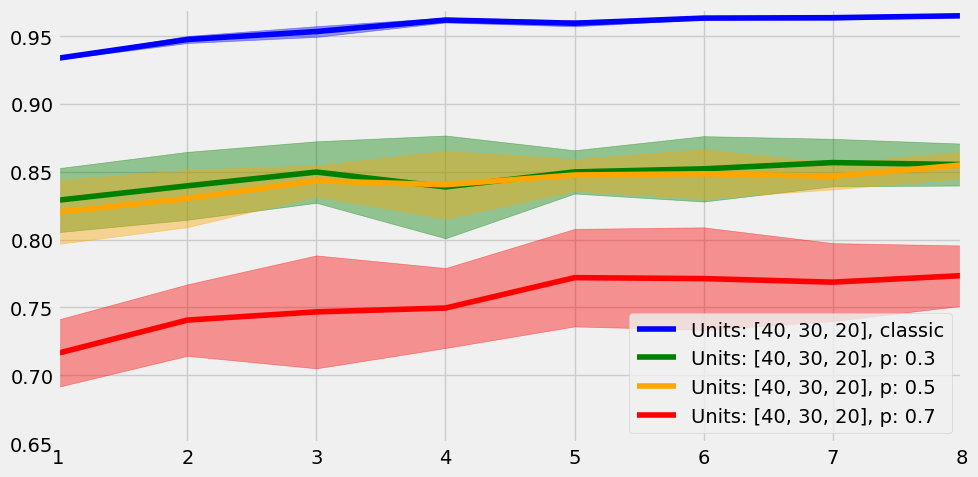

In [21]:
plot_many_paths([0, 1, 2, 3], edge_popup_dict, ylim=(0.65, 0.97))

Clearly, the network of the same size as classic one performs worse due to little room for pruning. As expected, there should be some good value for `p`, exceding which leads into even worse results (like 0.7 dropped the accuracy significantly).

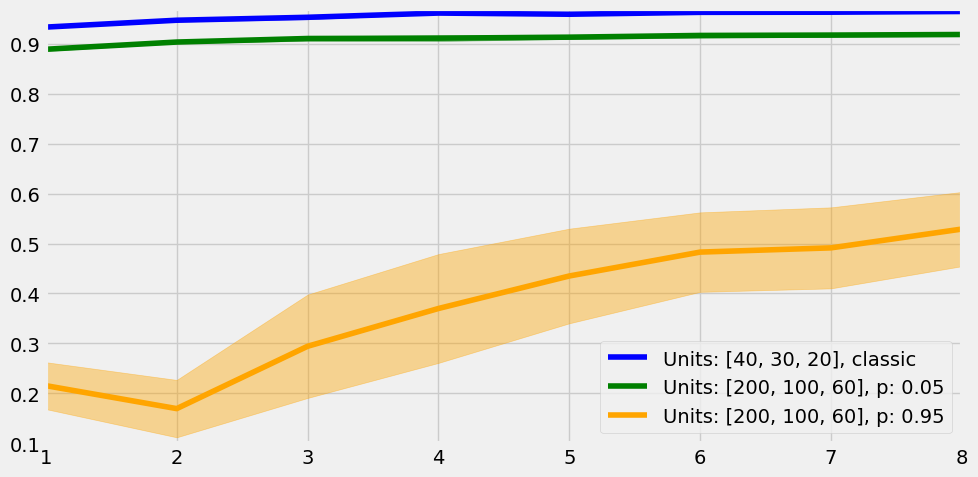

In [22]:
plot_many_paths([0, 4, 5], edge_popup_dict, ylim=(0.10, 0.97))

After making the layers' widths greater there's another thing to note: little pruning makes the network find its masks for quite good performance around 90% but high rate of pruning effectively limits the network's capability of reaching anything reasonable. It also leads into higher uncertainty (wider yellow shadow).

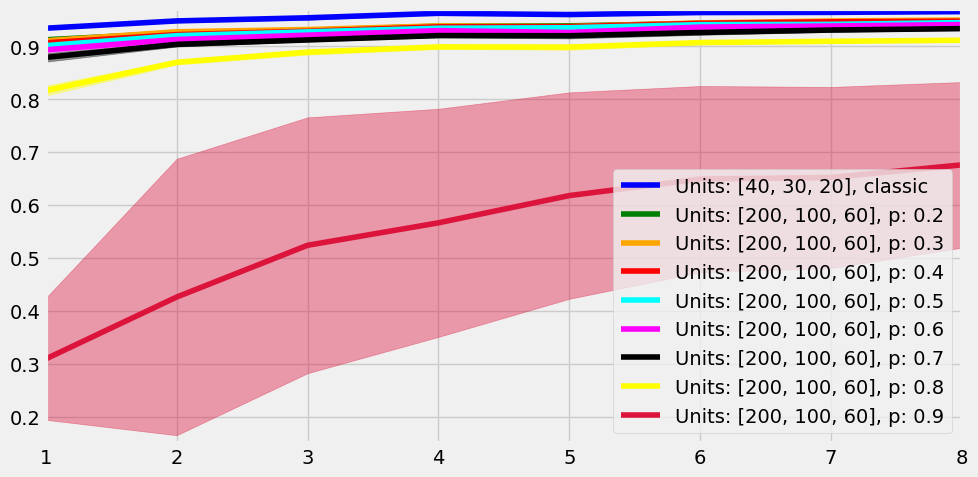

In [23]:
plot_many_paths([0, 7, 8, 9, 10, 11, 12, 13, 14], edge_popup_dict, ylim=(0.15, 0.97))

From all tried values for `p` the highest one (0.9) produces extremely high uncertainty and worst performance. All the rest makes it possible for the network to exceed 90% after 8 epochs of training.

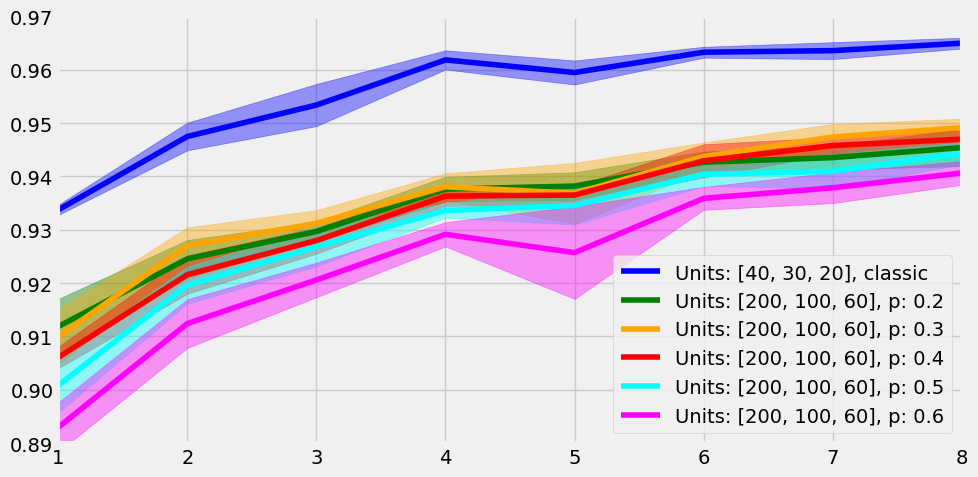

In [24]:
plot_many_paths([0, 7, 8, 9, 10, 11], edge_popup_dict, ylim=(0.89, 0.97))

Closer look reveals aggresive competition between all the values from 0.2 up to 0.6. The one that was chosen for the IteRand model is 0.3 due to its best final mean accuracy and overall performance at each stage of training.

## IteRand

Now we want to add iterative randomization to the training and look for optimal values for `Kper` and `r`. For all IteRand networks `p` is set to 0.3.

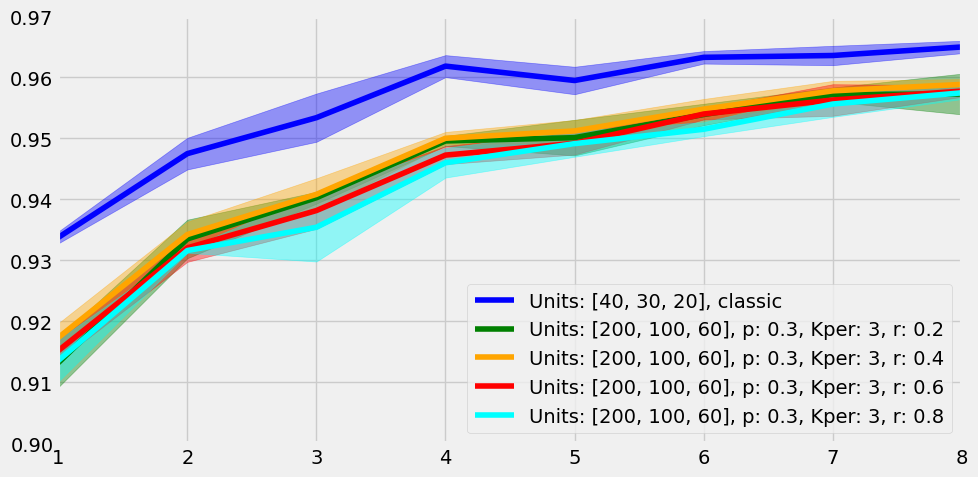

In [25]:
plot_many_paths([0, 1, 2, 3, 4], iterand_dict, ylim=(0.90, 0.97))

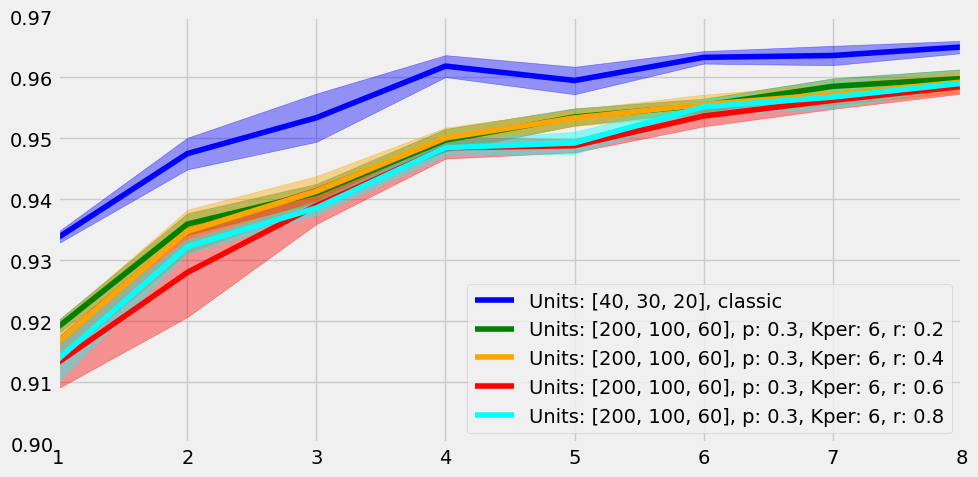

In [26]:
plot_many_paths([0, 5, 6, 7, 8], iterand_dict, ylim=(0.90, 0.97))

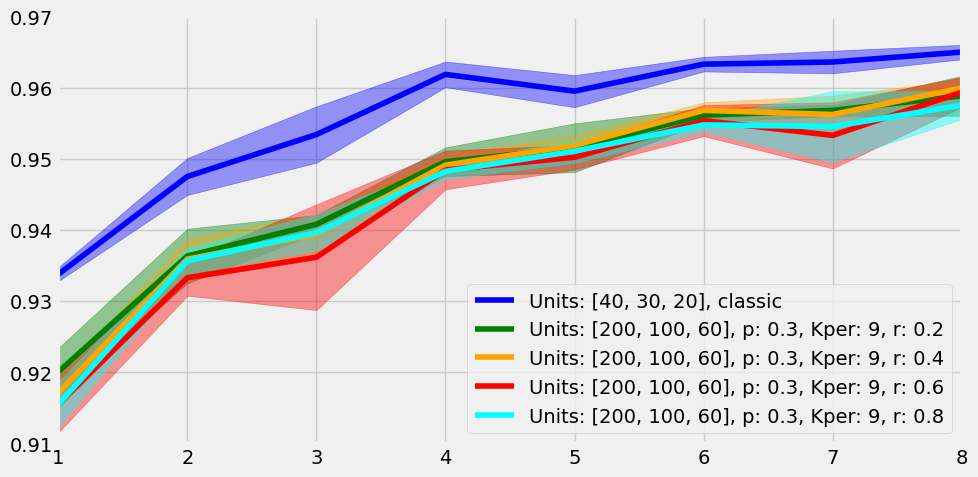

In [27]:
plot_many_paths([0, 9, 10, 11, 12], iterand_dict, ylim=(0.91, 0.97))

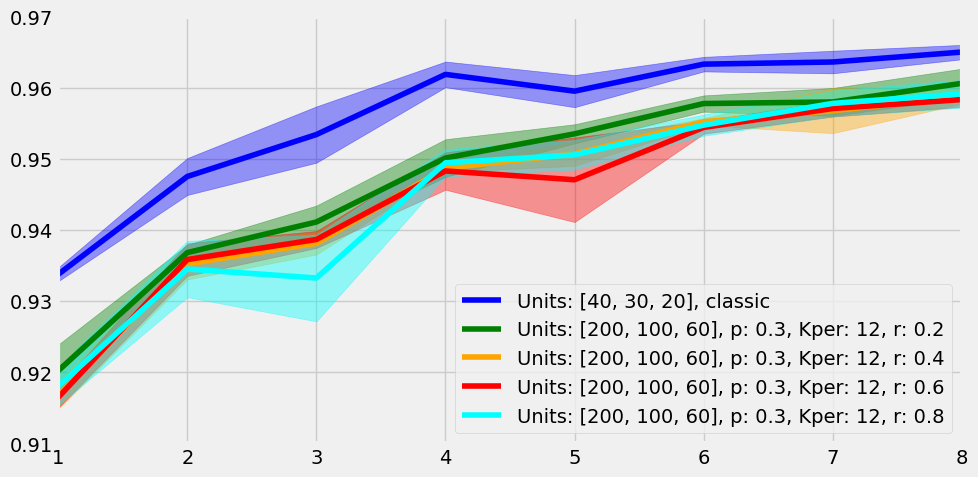

In [28]:
plot_many_paths([0, 13, 14, 15, 16], iterand_dict, ylim=(0.91, 0.97))

Even though the iterative randomization's impact varies from little to huge, the results are quite similar. All models with `Kper` of 3, 7, 9 or 12 and `r` of 0.2, 0.4, 0.6, 0.8 ended up above 95%. The one that seems to be the winner is `Kper=12, r=0.2`, which was the best across all epochs.

## All best

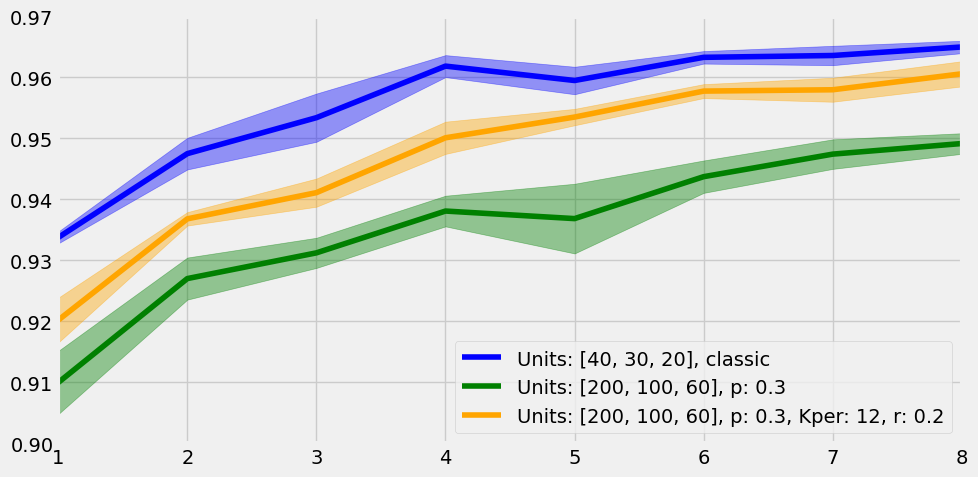

In [29]:
plot_many_paths([0, 8] + [len(edge_popup_dict) - 1 + 13], edge_popup_dict | iterand_dict, ylim=(0.90, 0.97))

Clearly, the edge-popup algorithm can lead into reasonable results compared to classic model and adding iterative randomization improves it significantly. Note that we used only dense layers and single, arbitrary set of layers' widths. Considering more challenging task requiring using CNN or RNN or even more complex architectures may lead into network pruning algorithms shine.

Also one could try adding more layers to the models which is actually closer to the theory presented in the papers mentioned at the beginning (the theorem proving pruning's effectives assumes pruned network to comprise of 2 times more layers). However, due to long training time we resigned from trying this option.

# Time trial

In [30]:
%%timeit -r 1 -n 5

classic_model = prepare_classic_model(n_units=[40, 30, 20], learning_rate=0.03)
classic_model.fit(**fit_params)

29.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [31]:
%%timeit -r 1 -n 5

edge_popup_model = prepare_edge_popup_model(n_units=[200, 100, 60], ps=0.3, learning_rate=1.0)
edge_popup_model.fit(**fit_params)

5min 48s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [32]:
%%timeit -r 1 -n 5

iterand_model = prepare_iterand_model(n_units=[200, 100, 60], ps=0.3, Kpers=12, rs=0.2, learning_rate=1.0)
iterand_model.fit(**fit_params)

5min 50s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


For models we tried in these experiments the edge-popup algorith needs almost 12 times as much time to train a network. Iterative randomization seems to require little amount of additional time but even with it the networks stay behind classic SGD approach. That big inefficiency makes using pruning algorithms simply impractical. Because of that we don't expect them to replace gradient-descent-based methods soon but further development may eventually produce efficient pruning implementations.